In [110]:
import pandas as pd
import numpy as np
import matplotlib as plt
import glob
import re

projects = pd.read_json("../projects.json")
all_files = glob.glob("../*/*.json")

def attempt(fn, catch):
  def _inner(*args, **kwargs):
      try:
          return fn(*args, **kwargs)
      except Exception as e:
          return catch(e, args, kwargs)
  return _inner


read_json = attempt(lambda f: pd.read_json(f), lambda e, args, ignored: print("Failed to read", args[0]))
all_data_map = {f: read_json(f) for f in all_files}
is_result = lambda r: r.tag == "FileStats"

Failed to read ../nodejs/node-2018-12-31.json
Failed to read ../mui-org/material-ui-2018-12-31.json


# Projects



In [111]:
projects = projects.drop_duplicates(subset=["url"], keep="last")
projects["id"] = projects["id"].apply(lambda x: re.sub(r"/+", "/", x))


In [112]:
def filter_project_files(pattern, data):
    return {k: df for (k, df) in data.items() if pattern in k}

head = lambda c: next(iter(c)) if len(c) > 0 else None
get_num_files = lambda m_df: len(m_df) if m_df is not None else None
project_files = projects["id"].apply(lambda n: filter_project_files(n, all_data_map))
project_files_by_year = (project_files
    .apply(lambda m: {year: filter_project_files("-" + year + "-", m).values() for year in ("2009", "2012", "2015", "2018")})
                         )

projects["numJsFiles"] = (
    project_files_by_year
    .apply(lambda d: {y: get_num_files(head(d[y])) for y in d.keys()})
)

In [113]:
only_valid = lambda df: df[df["tag"] == "FileStats"]
map_none = lambda f: lambda v: f(v) if v is not None else None
only_valid_ = map_none(only_valid)
get_loc = lambda df: df["linesOfCode"].sum() if not df.empty else 0
get_loc_ = map_none(get_loc)
map_values = lambda f: lambda d: {k: f(v) for (k, v) in d.items()}

project_df_year = project_files_by_year.apply(map_values(head))
project_df_valid_year = project_df_year.apply(map_values(map_none(attempt(only_valid_, lambda *a, **kwg: None))))
projects["linesOfCode"] = project_df_valid_year.apply(map_values(get_loc_))


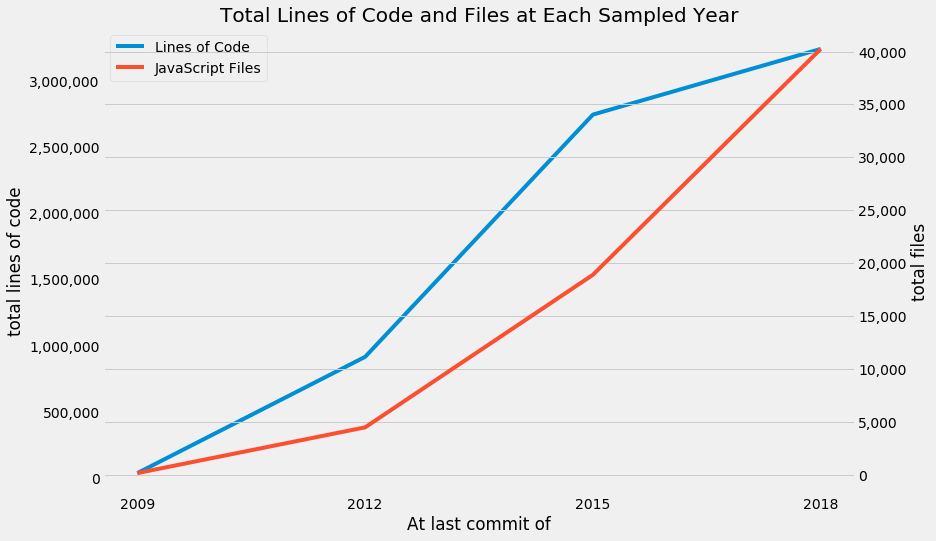

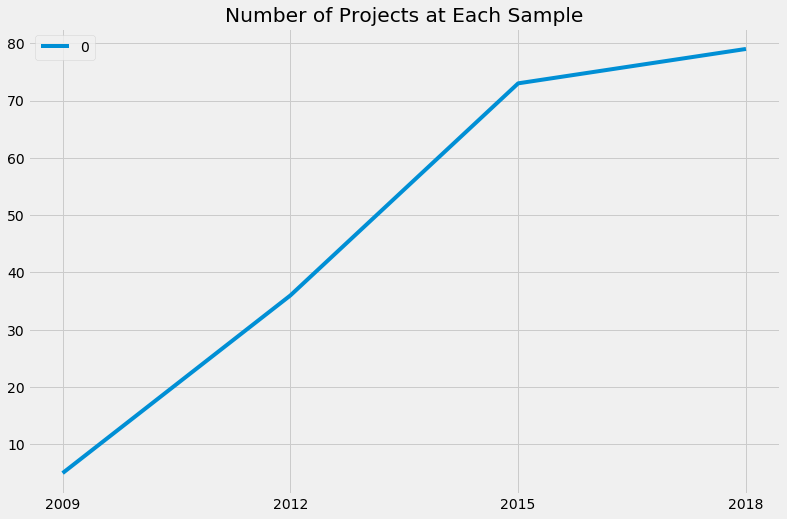

In [196]:
import math
plt.style.use("fivethirtyeight")
plt.rcParams["figure.figsize"] = (12, 8)
loc_per_year = pd.DataFrame(list(projects["linesOfCode"])).sum().reset_index().rename(columns={"index": "year"})
loc_per_year_ax = loc_per_year.plot(xticks=loc_per_year.index)
loc_per_year_ax.set_title("Total Lines of Code and Files at Each Sampled Year")
loc_per_year_ax.set_xlabel("At last commit of")
loc_per_year_ax.set_ylabel("total lines of code")
loc_per_year_ax.set_xticklabels(loc_per_year["year"])
loc_per_year_ax.set_label("Lines of Code")
yticks = loc_per_year_ax.get_yticks()
loc_per_year_ax.set_yticklabels(["{:,.0f}".format(y) for y in yticks])

files_per_year = pd.DataFrame(list(projects["numJsFiles"])).sum().reset_index().rename(columns={"index": "year"})
files_per_year_ax = files_per_year.plot(ax=loc_per_year_ax, xticks=files_per_year.index, secondary_y=True)
files_per_year_ax.set_ylabel("total files")
files_per_year_ax.set_label("JavaScript Files")
yticks = files_per_year_ax.get_yticks()
files_per_year_ax.set_yticklabels(["{:,.0f}".format(y) for y in yticks])

projects_w_data = pd.DataFrame(list(projects["numJsFiles"])).count().reset_index().rename(columns={"index": "year"})
projects_w_data_ax = projects_w_data.plot(xticks=projects_w_data.index, title="Number of Projects at Each Sample")
projects_w_data_ax.set_xticklabels(projects_w_data.year)

loc_per_year_ax.legend(loc_per_year_ax.get_legend().get_lines(), ["Lines of Code", "JavaScript Files"])

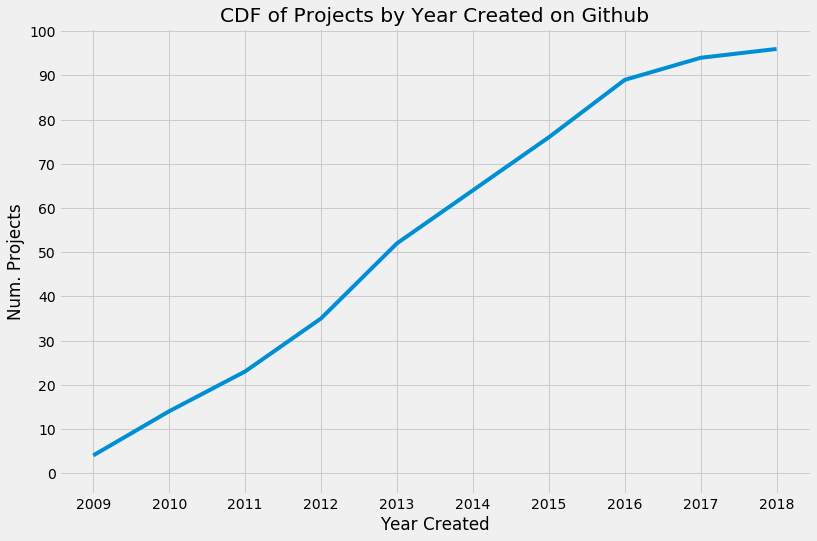

In [316]:
projects_by_year = projects["createdAt"].apply(pd.to_datetime).apply(lambda x: x.year)
projects_count_year = projects_by_year.reset_index().groupby(by="createdAt").count().reset_index().rename(columns={"index": "numProjects"})
projects_age_ax = projects_count_year["numProjects"].cumsum().plot(xticks=projects_count_year.index,
                                                                   yticks=range(0, 110, 10),
                                                                  )
projects_age_ax.set_title("CDF of Projects by Year Created on Github")
projects_age_ax.set_ylabel("Num. Projects")
projects_age_ax.set_xlabel("Year Created")
projects_age_ax.set_xticklabels(projects_count_year["createdAt"])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


year
2009     3
2010     6
2011    12
2012    24
2013    24
2014    26
2015    50
2016    37
2017    38
2018    86
Name: fnLibs, dtype: int64

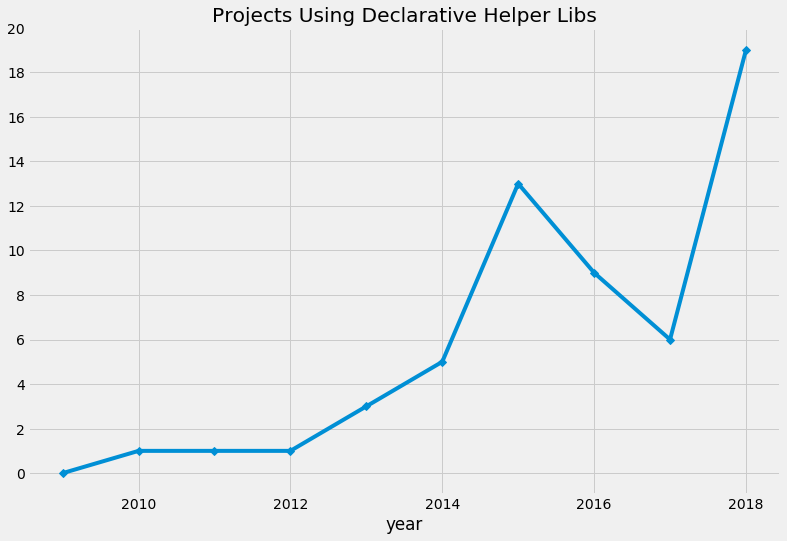

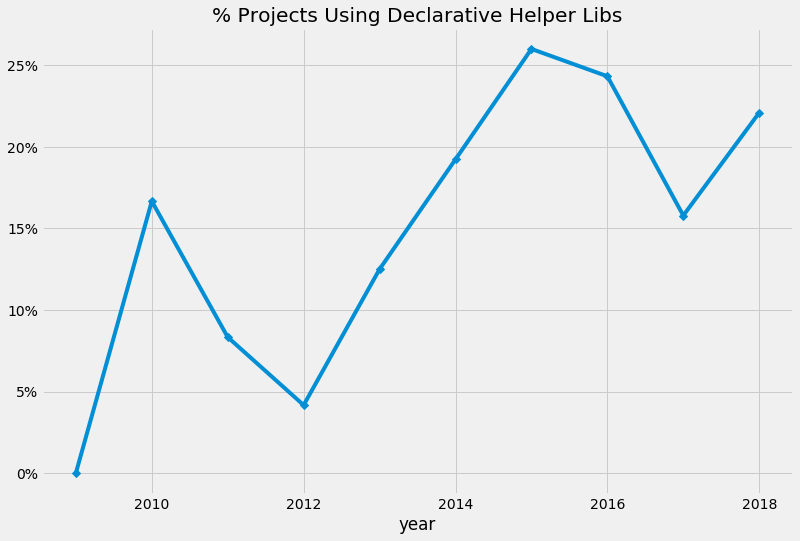

In [451]:
from pandas.io.json import json_normalize
pd.DataFrame(projects["revisions"].values[2])
revisions = pd.concat([json_normalize(rv).assign(projectId=i) for (i, rv) in projects[["id", "revisions"]].values])
revisions["year"] = revisions["committedDate"].apply(pd.to_datetime).apply(lambda x: x.year)
revisions = revisions.drop_duplicates(subset=["year", "projectId"], keep="last")
revisions = revisions[revisions["year"] != 2019]
revisions = revisions.set_index(["projectId", "year"])

def normalize_names(names):
    return [re.sub(r"[- ./_\\]", "-", n).lower() for n in names] if names else []


# List of libraries is taken from https://github.com/stoeffel/awesome-fp-js/blob/master/README.md
helper_libs = normalize_names([
    "Ramda",
    "Ramda Adjunct",
    "Ramda-extension",
    "Rambda",
    "lodash",
    "underscore",
    "Folktale",
    "lodash/fp",
    "functional.js",
    "101",
    "fnuc",
    "barely-functional",
    "bluebird-promisell",
    "prelude.ls",
    "preludejs",
    "1-liners",
    "fn-curry",
    "curry",
    "compose-function",
    "functionize",
    "lambdajs",
    "fp-dom",
    "trifl",
    "funcy",
    "date-fp",
    "js-joda",
    "\_part\_",
    "claire",
    "FPO.js",
    "Javascript Parser Combinator",
    "fun-task",
    "most",
    "zen-signals",
    "funfix",
    "pico-lambda",
    "pareto-js",
    "fpEs",
    "Creed",
])
data_structures_libs = normalize_names([
    "Icepick",
    "Immutable.js",
    "Immer",
    "Mori",
    "Baobab",
    "immutable-sequence.js",
    "Timm",
    "Lazy.js",
    "DerivableJS",
    "imlazy",
    "collectable",
    "List",
    "prelude.ts",
    "TSTL",
])
adt_libs = normalize_names([
    "immutable-ext",
    "daggy",
    "Sanctuary",
    "monet.js",
    "union-type",
    "freeky",
    "Fluture",
    "fantasy-combinators",
    "fantasy-birds",
    "crocks",
    "kudo-js",
    "purify",
    "MojiScript",
])
lenses_libs = normalize_names([
    "lenses",
    "optics",
    "ramda-lens",
    "fantasy-lenses",
    "nanoscope",
    "partial.lenses",
    "shades",
])


def uses_one_of(libs):
    def compare(deps):
        return any(d == l for d in normalize_names(deps) for l in libs)
    return compare


def intersect(libs):
    def _inner(deps):
        return [d for d in normalize_names(deps) for l in libs if d == l]
    return _inner

    
revisions["usesHelpers"] = revisions["dependencies"].apply(uses_one_of(helper_libs))
revisions["fnLibs"] = revisions["dependencies"].apply(intersect(helper_libs))

fig1, ax1 = plt.pyplot.subplots()
fig2, ax2 = plt.pyplot.subplots()
revisions["usesHelpers"].groupby(by="year").sum().plot(
    title="Projects Using Declarative Helper Libs", 
    yticks=range(0, 22, 2),
    ax=ax1,
    style="D-"
)

revisions["usesHelpers"].groupby(by="year").sum().divide(
    revisions["usesHelpers"].groupby(by="year").count()
).plot(title="% Projects Using Declarative Helper Libs", ax=ax2, style="D-")
ax2.set_yticklabels(["{:.0%}".format(v) for v in ax2.get_yticks()])

revisions["fnLibs"].groupby("year").

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


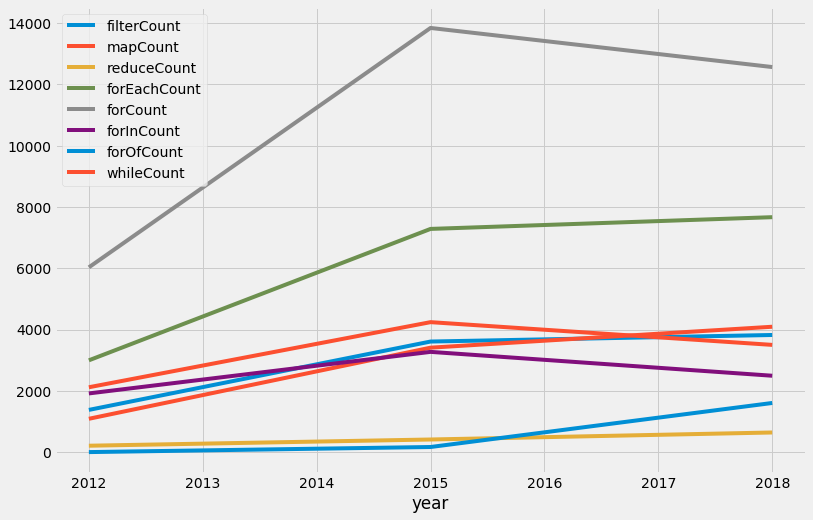

In [493]:
from functools import reduce
from os.path import basename

split_project_path = lambda fp: re.split(r"-(\d+-\d+-\d+)", basename(fp))
project_name_from_path = lambda fp: split_project_path(fp)[0]
project_date_from_path = lambda fp: split_project_path(fp)[1]
juxt = lambda *fs: lambda x: tuple(f(x) for f in fs)
def add_column(name, val, df):
    df[name] = val
    return df
all_data_with_names = pd.concat([add_column("commitDate", project_date_from_path(p),
            add_column("projectName", project_name_from_path(p), v)
           ) for (p, v) in all_data_map.items() if v is not None],
                               sort=False)

valid_data_with_names = only_valid(all_data_with_names)
valid_data_with_names["year"] = valid_data_with_names["commitDate"].apply(pd.to_datetime).apply(lambda x: x.year)
years_2012_2018 = valid_data_with_names[valid_data_with_names["year"].apply(lambda y: y in (2012, 2015, 2018))]
sums_by_year = years_2012_2018.groupby("year").sum()

Text(0.5, 0, 'Sample Year')

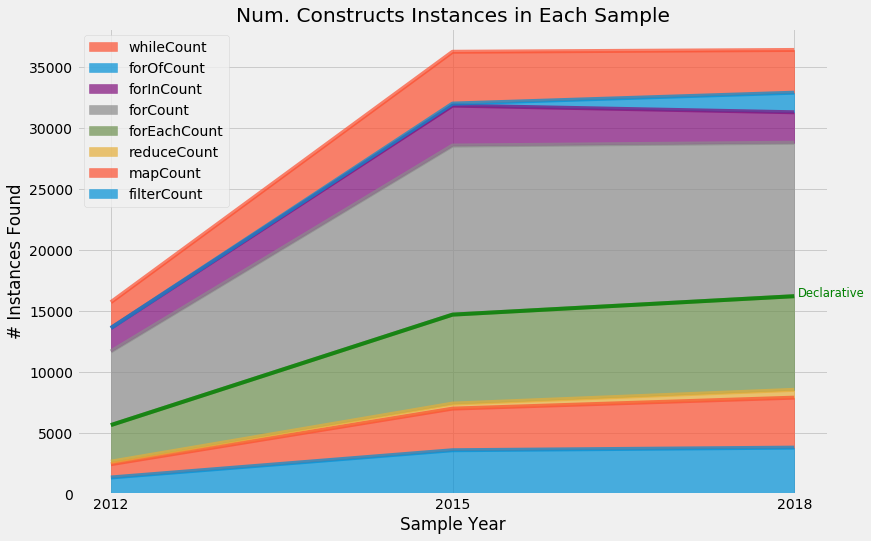

In [565]:
decl_metrics = ["filterCount", "mapCount", "reduceCount", "forEachCount",]
impe_metrics = ["forCount", "forInCount", "forOfCount", "whileCount"]
metrics = decl_metrics + impe_metrics
sums_by_year_ = sums_by_year.reset_index()
ax1 = sums_by_year_[metrics].plot(
    kind="area",
    title="Num. Constructs Instances in Each Sample",
    alpha=0.7,
    legend="reverse",
    xticks=sums_by_year_.index,
)
ax1.plot(
    sums_by_year_.index, 
    sums_by_year_[decl_metrics].sum(axis="columns"), 
    linewidth=4,
    alpha=0.8,
    color="green")
ax1.text(2.01, 
         sums_by_year_[decl_metrics].sum(axis="columns").tail(1), 
         'Declarative',
         horizontalalignment='left', size='small', color='green'
        )
ax1.set_ylabel("# Instances Found")
ax1.set_xticklabels(sums_by_year_["year"])
ax1.set_xlabel("Sample Year")

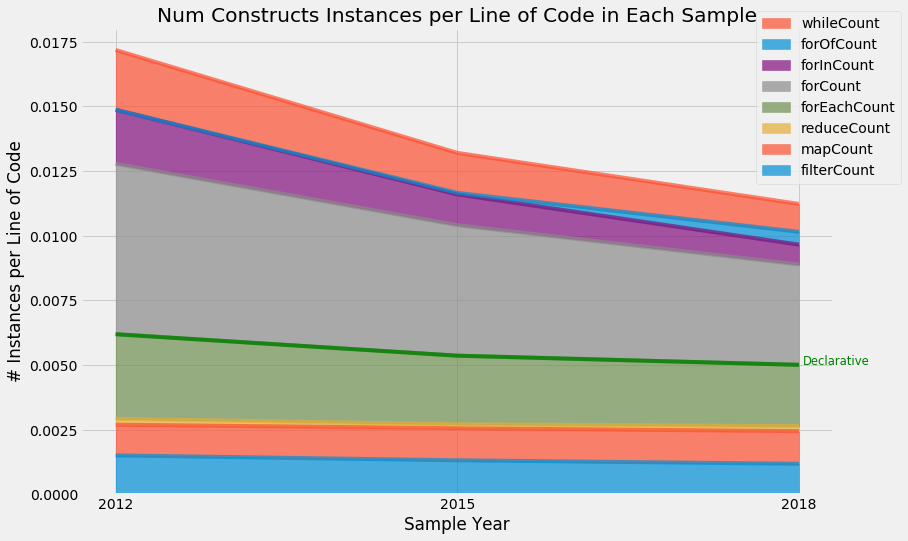

In [564]:
constructs_per_loc = sums_by_year_[metrics].apply(lambda c: c / sums_by_year_["linesOfCode"], axis="index")
ax2 = constructs_per_loc.plot(
    kind="area",
    title="Num Constructs Instances per Line of Code in Each Sample",
    alpha=0.7,
    xticks=sums_by_year_.index
)
ax2.plot(
    constructs_per_loc.index, 
    constructs_per_loc[decl_metrics].sum(axis="columns"), 
    linewidth=4,
    alpha=0.8,
    color="green")
ax2.text(2.01, 
         constructs_per_loc[decl_metrics].sum(axis="columns").tail(1), 
         'Declarative',
         horizontalalignment='left', size='small', color='green'
        )
ax2.set_ylabel("# Instances per Line of Code")
ax2.set_xticklabels(sums_by_year_["year"])
ax2.set_xlabel("Sample Year")
ax2_handles, ax2_labels = ax2.get_legend_handles_labels()
ax2.legend(ax2_handles[::-1], ax2_labels[::-1], bbox_to_anchor=(1.1, 1.05))
total_used = sums_by_year_[metrics].sum(axis="columns")

,filterCount,mapCount,reduceCount,forEachCount,forCount,forInCount,forOfCount,whileCount
0,0.087551,0.069112,0.013225,0.190425,0.383393,0.121757,0.000000,0.134537
1,0.099580,0.094060,0.011344,0.201038,0.382066,0.090279,0.004582,0.117051
2,0.105055,0.112449,0.017592,0.210742,0.345428,0.068497,0.044061,0.096177


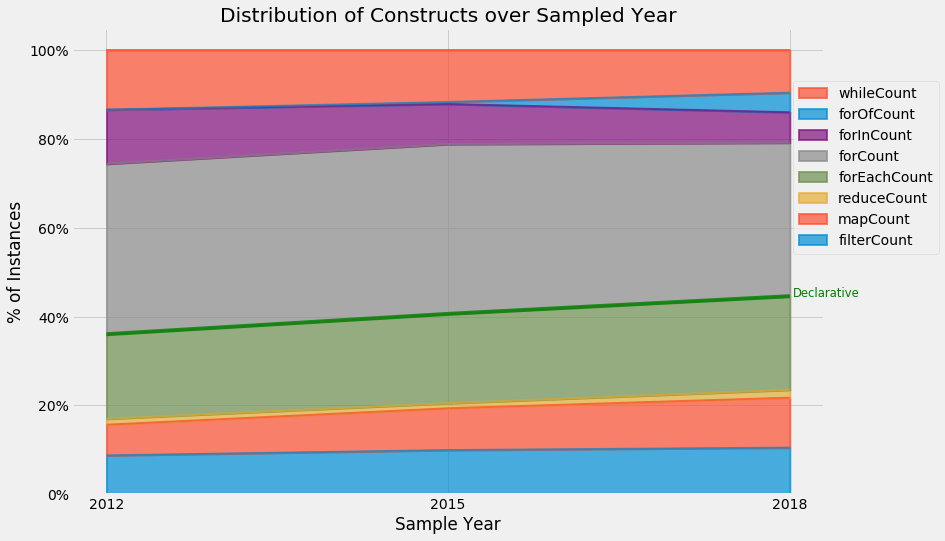

In [568]:
percentage_constructs = sums_by_year_[metrics].divide(total_used, axis="index")
ax3 = percentage_constructs.plot(
    kind="area", 
    title="Distribution of Constructs over Sampled Year",
    alpha=0.7,
    linewidth=2,
    legend="reverse",
    xticks=sums_by_year_.index
)
ax3.plot(
    percentage_constructs.index, 
    percentage_constructs[decl_metrics].sum(axis="columns"), 
    linewidth=4,
    alpha=0.8,
    color="green")
ax3.text(2.01, 
         percentage_constructs[decl_metrics].sum(axis="columns").tail(1), 
         'Declarative',
         horizontalalignment='left', size='small', color='green'
        )
ax3.set_ylabel("% of Instances")
ax3.set_xticklabels(sums_by_year_["year"])
ax3_handles, ax3_labels = ax3.get_legend_handles_labels()
ax3.legend(ax3_handles[::-1], ax3_labels[::-1], bbox_to_anchor=(0.95, 0.9))
ax3.set_xlabel("Sample Year")
ax3.set_yticklabels(["{:.0%}".format(v) for v in ax3.get_yticks()])
percentage_constructs

66

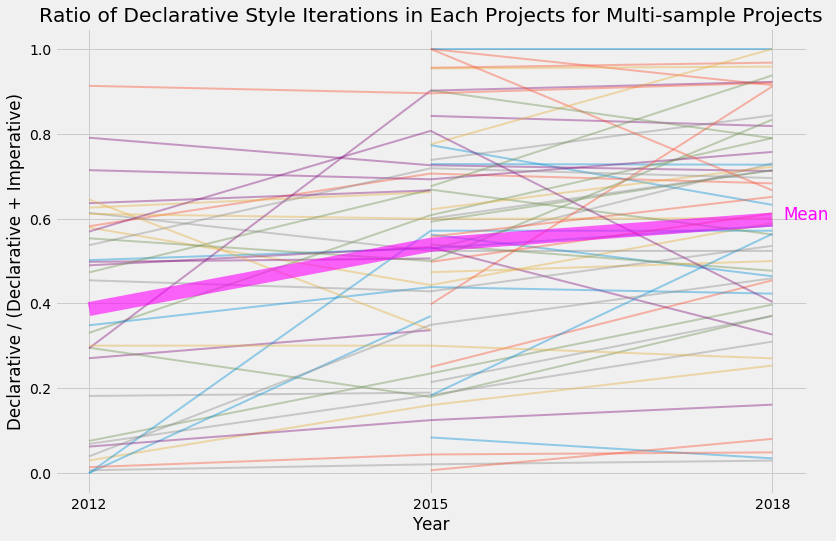

In [691]:
# Group by year and project
by_project_year = years_2012_2018.groupby(["projectName", "year"]).sum()

# Aggregate declarative and imperative togather
by_project_year["controlCount"] = by_project_year[decl_metrics + impe_metrics].sum(axis="columns")
by_project_year["declarativeCount"] = by_project_year[decl_metrics].sum(axis="columns")
by_project_year["imperativeCount"] = by_project_year[impe_metrics].sum(axis="columns")
by_project_year["declarativePerLoC"] = by_project_year["declarativeCount"].divide(by_project_year["linesOfCode"])
by_project_year["imperativePerLoC"] = by_project_year["imperativeCount"].divide(by_project_year["linesOfCode"])
by_project_year["declarativeRatio"] = by_project_year["declarativeCount"].divide(by_project_year["controlCount"])

by_project = years_2012_2018.groupby("projectName").nunique()
projects_with_more_than_1_sample = by_project[by_project["year"] > 1].index
projects_with_1_sample = by_project[by_project["year"] == 1].index
single_sample_projects = by_project_year[by_project_year.index.get_level_values("projectName").isin(projects_with_1_sample)]
multi_sample_projects = by_project_year[~by_project_year.index.get_level_values("projectName").isin(projects_with_1_sample)]

# Declarative Ratio for multi sample projects
declarative_ratio_multi_sample = multi_sample_projects["declarativeRatio"].unstack().T
axms = declarative_ratio_multi_sample.reindex().plot(
    title="Ratio of Declarative Style Iterations in Each Projects for Multi-sample Projects",
    linewidth=2,
    legend=False,
    alpha=0.4,
    xticks=declarative_ratio_multi_sample.reindex().index
)
axms.set_xlabel("Year")
axms.set_ylabel("Declarative / (Declarative + Imperative)")
axms.plot(declarative_ratio_multi_sample.reindex().index,
        multi_sample_projects["declarativeRatio"].unstack().mean(),
        color="magenta",
        alpha=0.6,
        linewidth=14,
       )
axms.text(2018.1,
         multi_sample_projects["declarativeRatio"].unstack().mean().tail(1),
         "Mean",
         color="magenta",
         size="large")